## Data Requirements

In [218]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from collections import Counter

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load dataset
bank = pd.read_csv('train.csv', sep=';')
bank.shape

(45211, 17)

In [6]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Understanding

In [7]:
# Get brief information
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
# Check duplicate
bank.duplicated().sum()

0

`Keterangan`: Dataset ini tidak memiliki nilai null, tidak memiliki nilai duplikat, dan tipe data setiap kolom sudah sesuai.

In [9]:
# Descriptive statistics
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [10]:
# Descriptive statistics
bank.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


`Keterangan`: Secara statistik, terdapat beberapa kolom yang terlihat skewed karena perbedaan mean dan median yang sangat jauh. Kolom-kolom tersebut adalah 'balance', 'duration', dan 'pdays'. Di samping itu, banyak kolom yang memiliki perbedaan nilai minimum dan maksimum yang sangat jauh.

In [11]:
# Split numerical and categorical columns
nums = [x for x in bank.select_dtypes(np.number).columns]
cats = [x for x in bank.select_dtypes(object).columns]

In [12]:
# Check value counts
for col in bank.columns:
    print(f"Value counts of '{col}'")
    print(bank[col].value_counts())
    print()

Value counts of 'age'
32    2085
31    1996
33    1972
34    1930
35    1894
      ... 
93       2
90       2
95       2
88       2
94       1
Name: age, Length: 77, dtype: int64

Value counts of 'job'
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Value counts of 'marital'
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

Value counts of 'education'
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

Value counts of 'default'
no     44396
yes      815
Name: default, dtype: int64

Value counts of 'balance'
 0        3514
 1         195
 2         156
 4         139
 3         134
          ... 
-381         1
 4617        1
 20584       1
 4358        1
 16353  

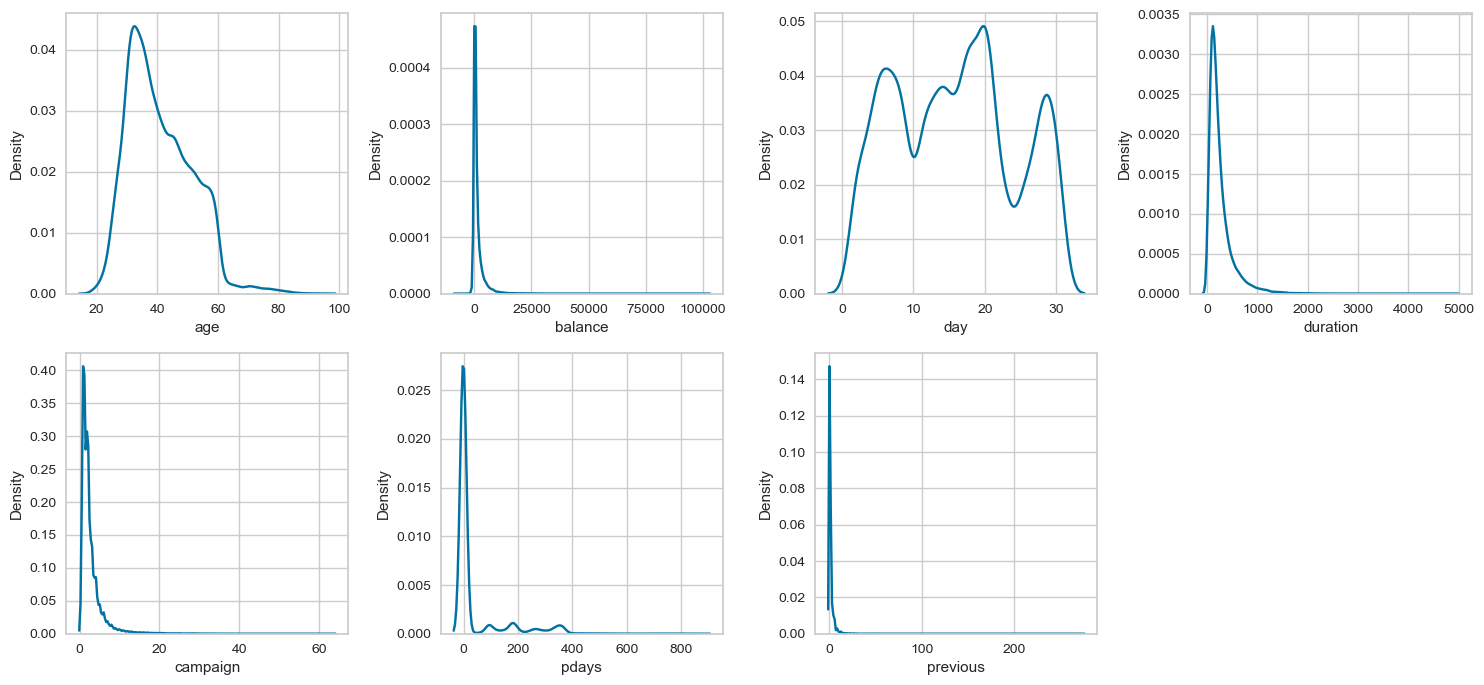

In [13]:
# Check distribution for numerical
plt.figure(figsize=(15,10))
for i in range(len(nums)):
    plt.subplot(3,4,i+1)
    sns.kdeplot(data=bank, x=bank[nums[i]])
    plt.tight_layout()

`Keterangan`: Terdapat 2 kolom yang dapat diasumsikan normal yaitu 'age' dan 'day', sedangkan sisanya adalah right skewed. Hal ini akan dilakukan penanganan di bagian selanjutnya

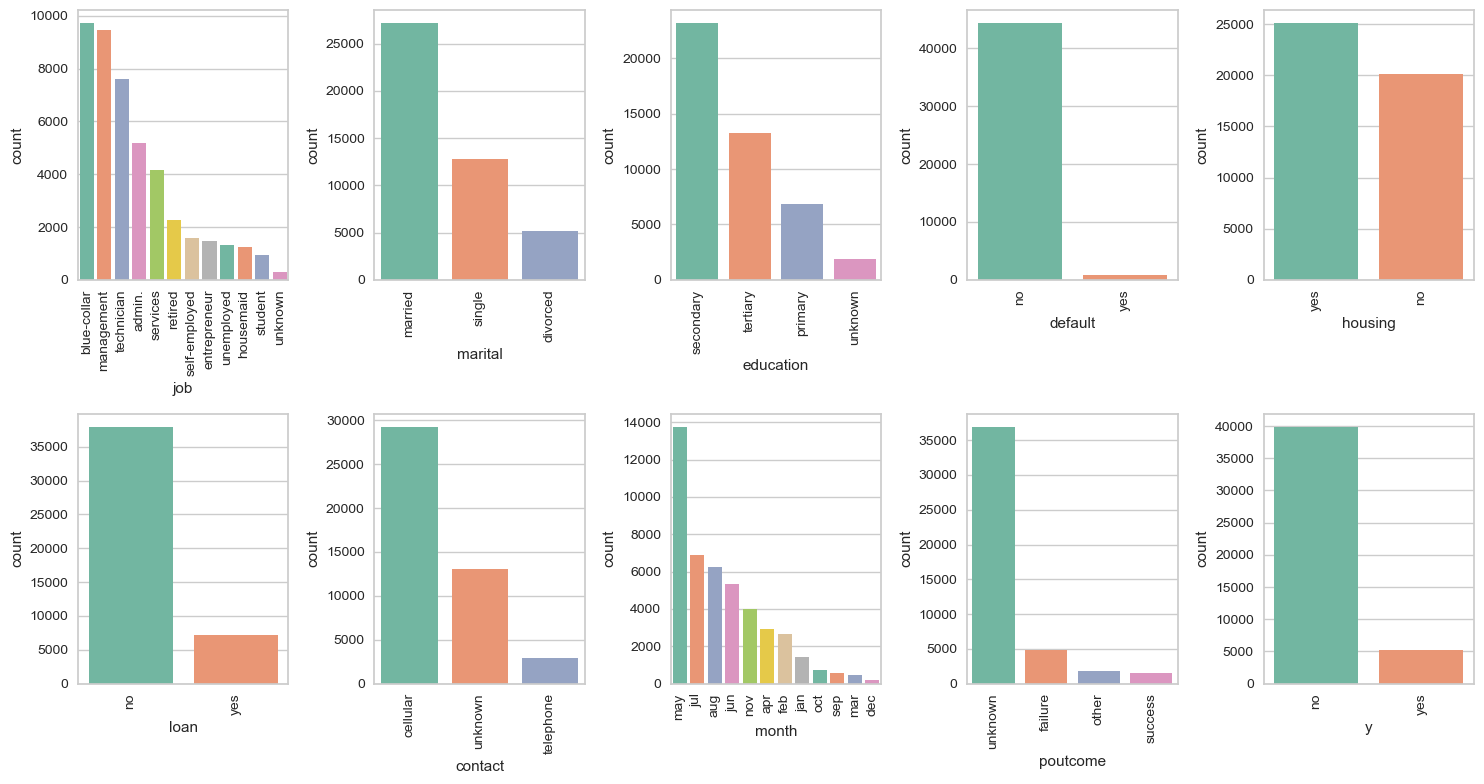

In [14]:
# Check distribution for categorical
plt.figure(figsize=(15,8))
for i in range(len(cats)):
    plt.subplot(2,5,i+1)
    sns.countplot(data=bank, x=bank[cats[i]], order=bank[cats[i]].value_counts().index, palette='Set2')
    plt.xticks(rotation=90)
    plt.tight_layout()

`Keterangan`: Kolom 'default', 'loan', 'poutcome', dan target 'y' memiliki perbedaan nilai yang sangat jauh (unbalanced) sehingga akan dilakukan penanganan di bagian selanjutnya

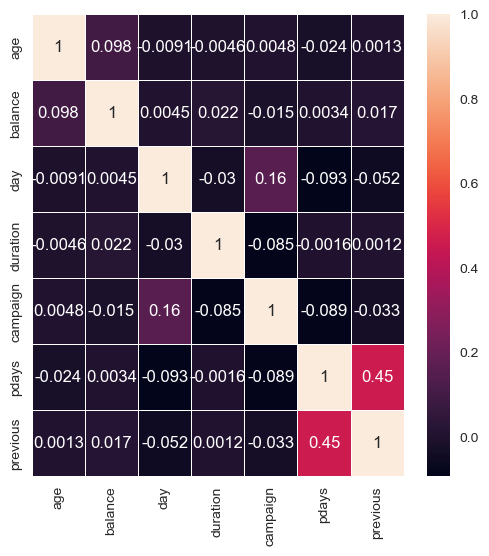

In [15]:
# Check correlation
plt.figure(figsize=(6,6))
sns.heatmap(bank.corr(method='pearson'), annot=True, linewidths=0.5, )
plt.show()

`Keterangan`: Melalui korelasi pearson dapat dilihat bahwa setiap fitur tidak memiliki korelasi yang tinggi namun terdapat fitur yang memiliki cukup korelasi yaitu antara 'pdays' dan 'previous'.

<Figure size 600x600 with 0 Axes>

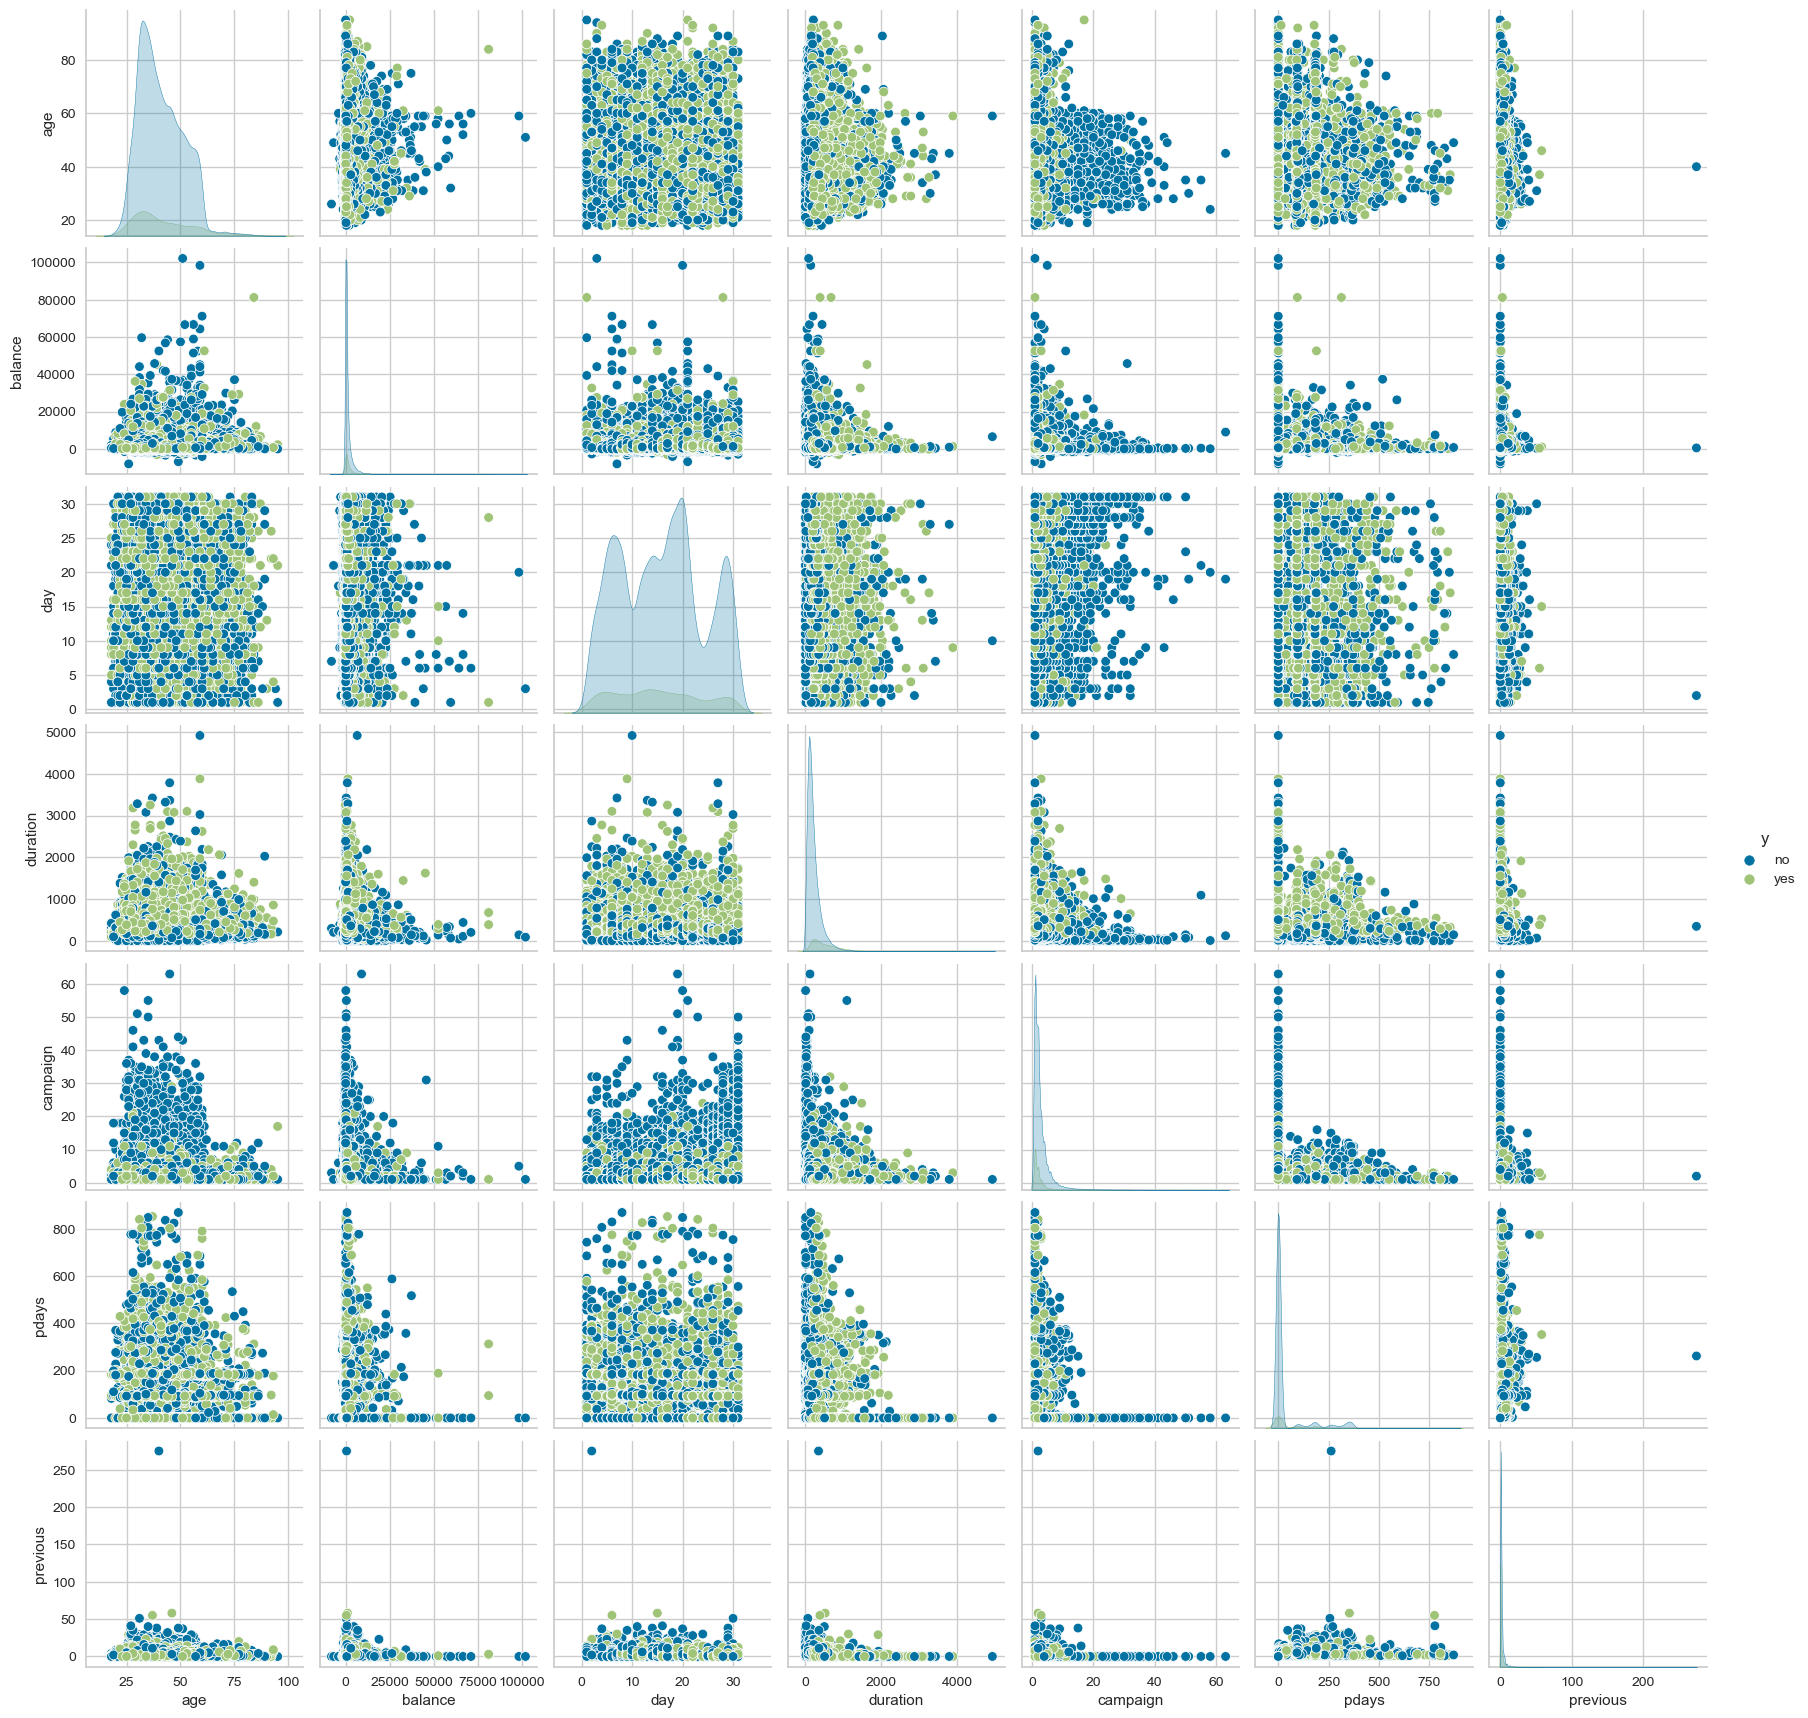

In [16]:
# Pairplot to see distribution of each two features
plt.figure(figsize=(6,6))
sns.pairplot(bank, hue='y')
plt.show()

`Keterangan`: Dapat dilihat persebaran target di setiap fitur tersebar secara acak dan tidak terlihat suatu pola tertentu.

### Insights

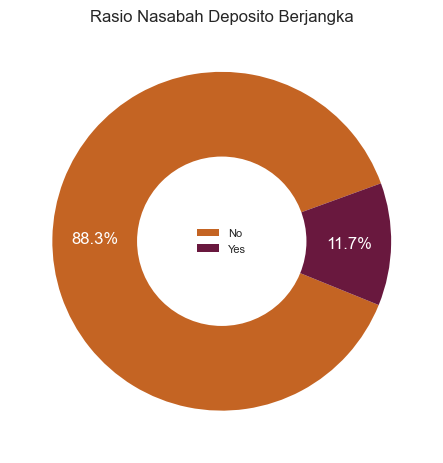

In [17]:
# Target
plt.pie(bank['y'].value_counts(),
        autopct='%1.1f%%',
        colors=['#c46423', '#69183e'],
        pctdistance=0.75,
        startangle=20,
        textprops={'color': 'white'})

center_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.legend(labels=['No','Yes'], loc='center', fontsize=8)
plt.title('Rasio Nasabah Deposito Berjangka')
plt.show()

`Keterangan`: Melalui kampanye telemarketing yang telah dilakukan, nasabah yang membeli layanan deposito berjangka hanyalah 11.7% atau sekitar 5289 orang saja.

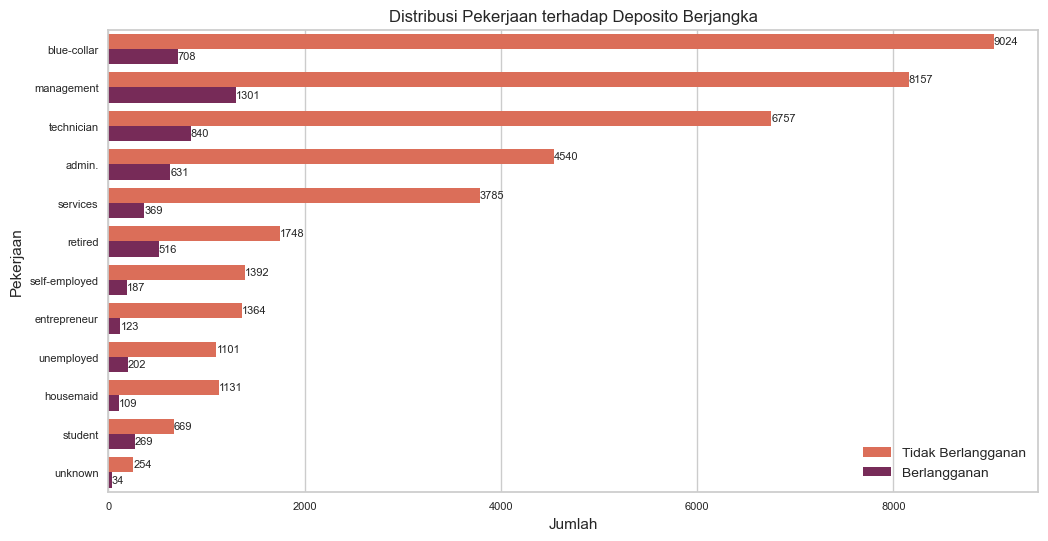

In [18]:
# Job with target
plt.figure(figsize=(12,6))
ax = sns.countplot(data=bank, y='job', order=bank['job'].value_counts().index, hue='y', palette='rocket_r')
for bar in ax.patches:
    ax.annotate(format(bar.get_width(), '.0f'),
                (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                ha='left', va='center', rotation='horizontal', fontsize=8)
ax.set_xlabel('Jumlah')
ax.set_ylabel('Pekerjaan')
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.title('Distribusi Pekerjaan terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Tidak Berlangganan','Berlangganan'])
plt.show()

`Keterangan`: Jenis pekerjaan yang paling banyak dihubungi adalah blue-collar. Meski demikian, jenis pekerjaan yang paling banyak berlangganan deposito berjangka adalah management dengan jumlah 1301 orang.

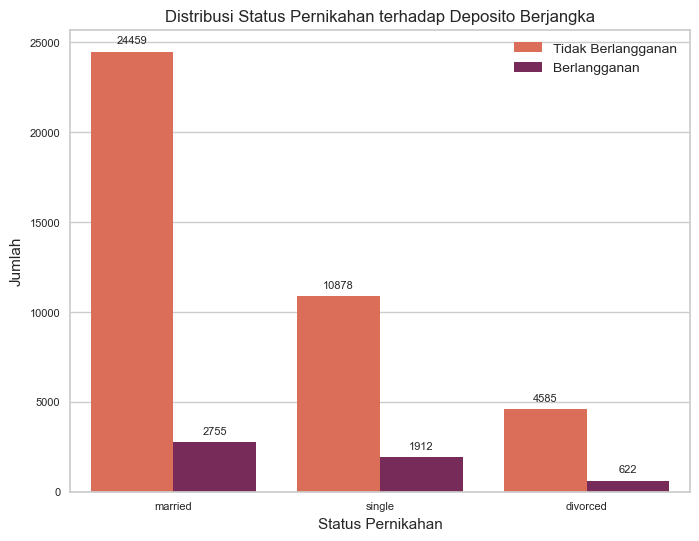

In [19]:
# Marital with target
plt.figure(figsize=(8,6))
ax = sns.countplot(data=bank, x='marital', order=bank['marital'].value_counts().index, hue='y', palette='rocket_r')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
ax.set_xlabel('Status Pernikahan')
ax.set_ylabel('Jumlah')
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.title('Distribusi Status Pernikahan terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Tidak Berlangganan','Berlangganan'])
plt.show()

`Keterangan`: Orang yang berlangganan deposito berjangka lebih banyak dilakukan oleh orang yang sudah menikah dengan jumlah 2755 orang.

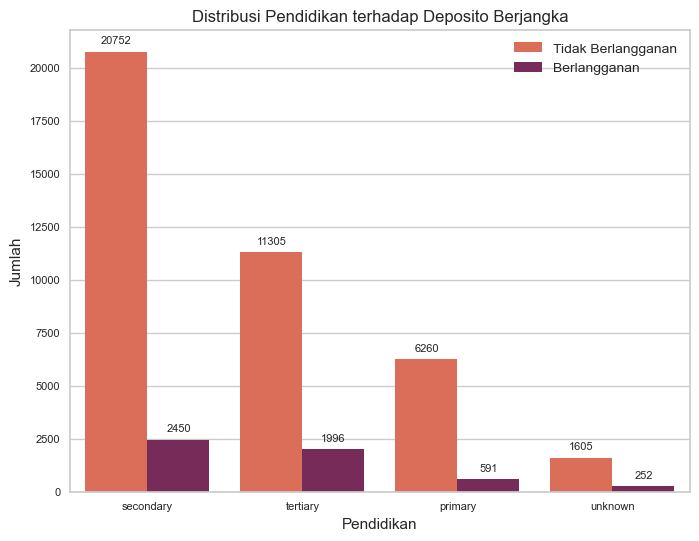

In [20]:
# Education with target
plt.figure(figsize=(8,6))
ax = sns.countplot(data=bank, x='education', order=bank['education'].value_counts().index, hue='y', palette='rocket_r')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
ax.set_xlabel('Pendidikan')
ax.set_ylabel('Jumlah')
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.title('Distribusi Pendidikan terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Tidak Berlangganan','Berlangganan'])
plt.show()

`Keterangan`: Dalam segi pendidikan, orang yang berlangganan deposito berjangka banyak dilakukan oleh orang yang berada pada pendidikan menengah.

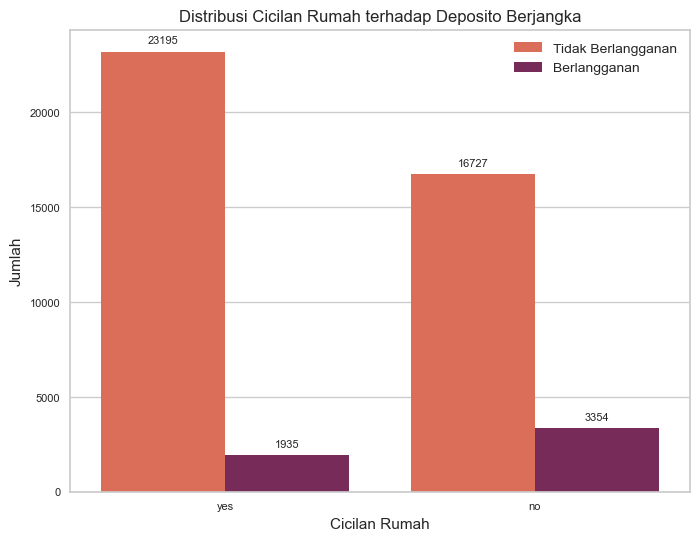

In [21]:
# Housing with target
plt.figure(figsize=(8,6))
ax = sns.countplot(data=bank, x='housing', order=bank['housing'].value_counts().index, hue='y', palette='rocket_r')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
ax.set_xlabel('Cicilan Rumah')
ax.set_ylabel('Jumlah')
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.title('Distribusi Cicilan Rumah terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Tidak Berlangganan','Berlangganan'])
plt.show()

`Keterangan`: Orang yang berlangganan deposito berjangka banyak yang tidak memiliki cicilan rumah.

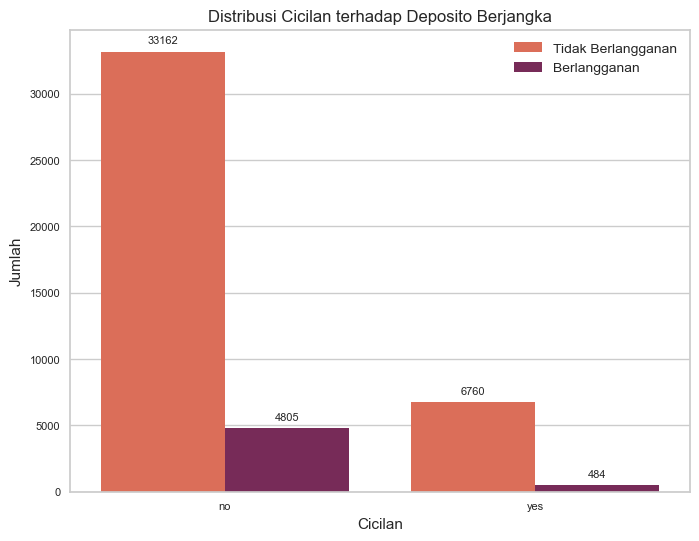

In [22]:
# Loan with target
plt.figure(figsize=(8,6))
ax = sns.countplot(data=bank, x='loan', order=bank['loan'].value_counts().index, hue='y', palette='rocket_r')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
ax.set_xlabel('Cicilan')
ax.set_ylabel('Jumlah')
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.title('Distribusi Cicilan terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Tidak Berlangganan','Berlangganan'])
plt.show()

`Keterangan`: Orang yang berlangganan deposito berjangka banyak yang tidak memiliki cicilan apa pun

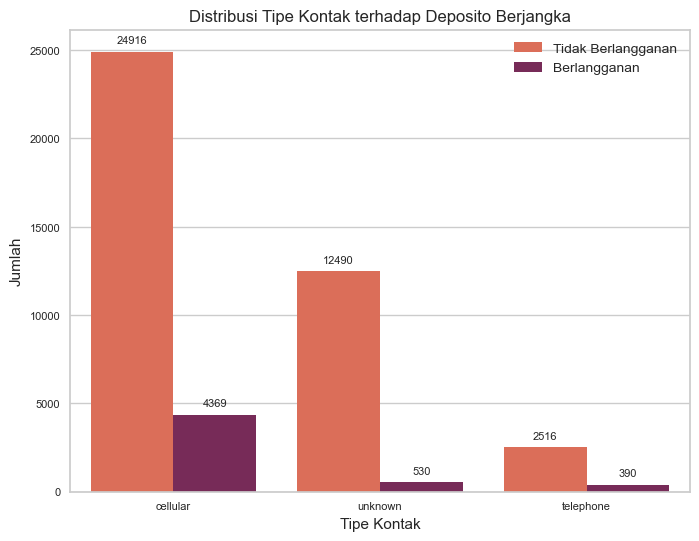

In [23]:
# Contact with target
plt.figure(figsize=(8,6))
ax = sns.countplot(data=bank, x='contact', order=bank['contact'].value_counts().index, hue='y', palette='rocket_r')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
ax.set_xlabel('Tipe Kontak')
ax.set_ylabel('Jumlah')
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.title('Distribusi Tipe Kontak terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Tidak Berlangganan','Berlangganan'])
plt.show()

`Keterangan`: Tipe kontak yang digunakan oleh orang yang berhasil berlangganan adalah cellular.

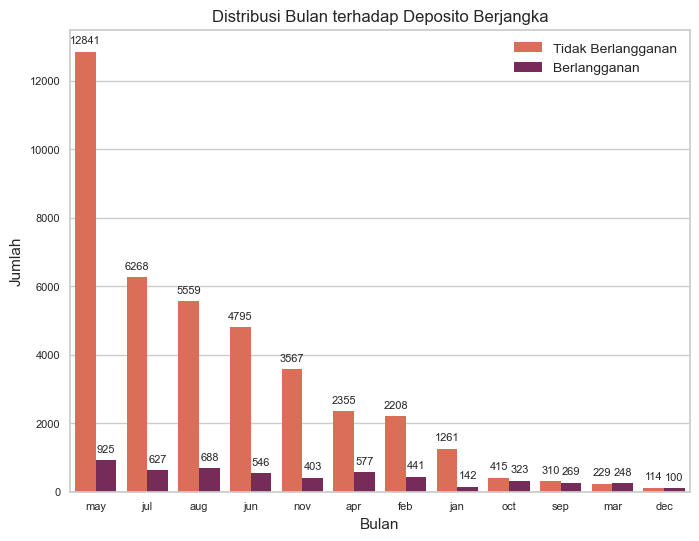

In [24]:
# Month with target
plt.figure(figsize=(8,6))
ax = sns.countplot(data=bank, x='month', order=bank['month'].value_counts().index, hue='y', palette='rocket_r')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
ax.set_xlabel('Bulan')
ax.set_ylabel('Jumlah')
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.title('Distribusi Bulan terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Tidak Berlangganan','Berlangganan'])
plt.show()

`Keterangan`: Kampanye telemarketing banyak dilakukan pada bulan Mei. Namun, persebaran orang yang berhasil berlangganan tidak terlalu signifikan jika dibandingkan dengan bulan lainnya.

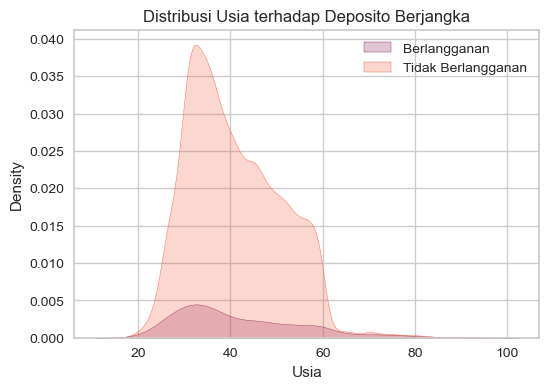

In [25]:
# Age with target
plt.figure(figsize=(6,4))
sns.kdeplot(data=bank, x='age', hue='y', fill=True, palette='rocket_r')
plt.xlabel('Usia')
plt.title('Distribusi Usia terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Berlangganan','Tidak Berlangganan'])
plt.show()

`Keterangan`: Usia yang paling banyak dihubungi berada pada rentang 25 sampai 50 tahun. Hal tersebut berkorelasi dengan usia orang-orang yang berlangganan deposito berjangka. Hal ini dapat terjadi karena usia tersebut merupakan usia produktif.

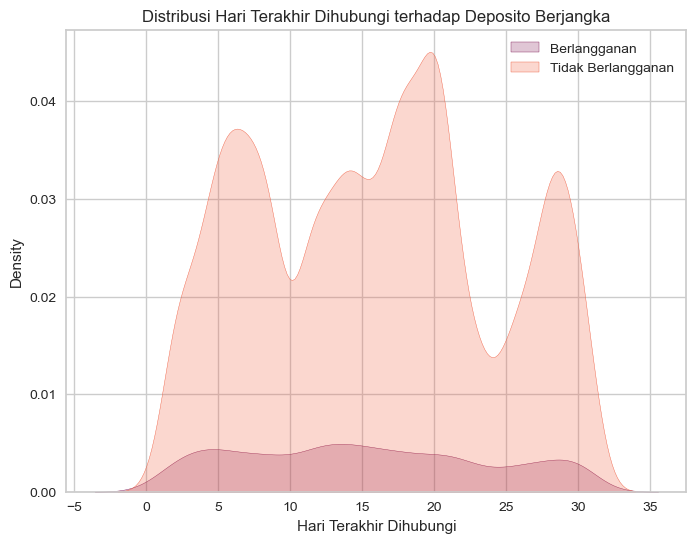

In [26]:
# Day with target
plt.figure(figsize=(8,6))
sns.kdeplot(data=bank, x='day', hue='y', fill=True, palette='rocket_r')
plt.xlabel('Hari Terakhir Dihubungi')
plt.title('Distribusi Hari Terakhir Dihubungi terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Berlangganan','Tidak Berlangganan'])
plt.show()

`Keterangan`: Jika dilihat melalui hari terakhir dihubungi, orang-orang yang berlangganan tidak cukup signifikan apabila dibandingkan dengan jumlah orang yang dihubungi. Hal ini menunjukkan bahwa orang dapat menerima layanan tersebut di hari apa saja.

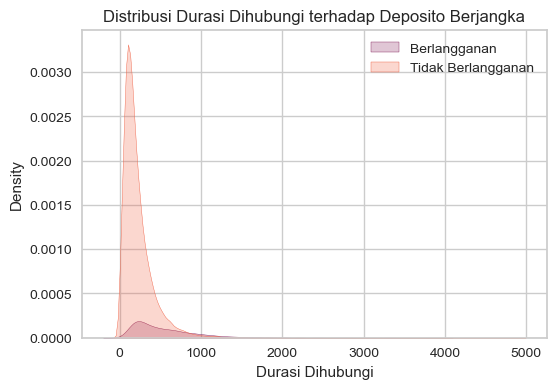

In [27]:
# Duration with target
plt.figure(figsize=(6,4))
sns.kdeplot(data=bank, x='duration', hue='y', fill=True, palette='rocket_r')
plt.xlabel('Durasi Dihubungi')
plt.title('Distribusi Durasi Dihubungi terhadap Deposito Berjangka', fontsize=12)
plt.legend(['Berlangganan','Tidak Berlangganan'])
plt.show()

`Keterangan`: Durasi melakukan telemarketing banyak dilakukan pada rentang 0 hingga 1000 detik. Hal ini serupa dengan orang-orang yang berlangganan yang mana mereka telah dihubungi selama 0 hingga 1000 detik.

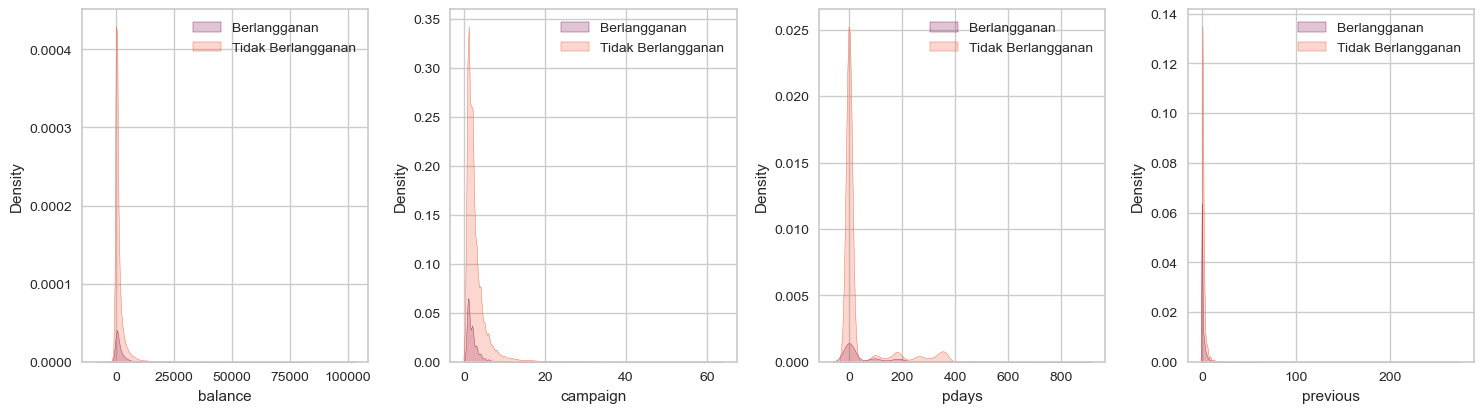

In [28]:
# Duration with target
co = ['balance', 'campaign', 'pdays', 'previous']
plt.figure(figsize=(15, 8))
for i in range(len(co)):
    plt.subplot(2,4,i+1)
    sns.kdeplot(data=bank, x=bank[co[i]], hue='y', fill=True, palette='rocket_r')
    plt.legend(['Berlangganan','Tidak Berlangganan'])
    plt.tight_layout()

`Keterangan`: 
- Pada kolom balance, orang yang melakukan langganan deposito berjangka memiliki rata-rata saldo tahunan 0
- Pada kolom campaign, orang yang melakukan langganan deposito berjangka dihubungi sebanyak sekitar 0 hingga 5 kali
- Pada kolom pdays dan previous, nilai 0 menunjukkan bahwa orang-orang memang baru dihubungi pertama kali selama kampanye ini berlangsung

## Data Preparation

In [86]:
# Take possible features based on data understanding
list_num = ['age','balance','duration','campaign']
list_cat = ['job','marital','education','housing','loan','contact','y']
bank_prep = bank.copy()
bank_prep = bank_prep[list_num + list_cat]
print(bank_prep.shape)

(45211, 11)


In [30]:
# # Handle outlier using IQR
# for col in list_num:
#     q1 = bank_prep[col].quantile(0.25)
#     q3 = bank_prep[col].quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - (iqr * 1.5)
#     upper = q3 + (iqr * 1.5)
#     outliers = ((bank_prep[col] >= lower) & (bank_prep[col] <= upper))

# bank_prep = bank_prep[outliers]
# print(bank_prep.shape)

In [161]:
# # Transform numerical data
# for col in list_num:
#     if bank_prep[col].min() == 0:
#         bank_prep[col] = np.log1p(bank_prep[col])
#     else:
#         bank_prep[col] = np.log(bank_prep[col])

In [87]:
# Encode categorical data
bank_prep['marital'] = bank_prep['marital'].replace({'married':2,'single':1,'divorced':0})
bank_prep['education'] = bank_prep['education'].replace({'tertiary':3,'secondary':2,'primary':1,'unknown':2})
bank_prep['housing'] = bank_prep['housing'].replace({'yes':1,'no':0})
bank_prep['loan'] = bank_prep['loan'].replace({'yes':1,'no':0})
bank_prep['contact'] = bank_prep['contact'].replace({'cellular':2,'telephone':1,'unknown':2})
bank_prep['y'] = bank_prep['y'].replace({'yes':1,'no':0})
bank_encoded = pd.get_dummies(bank_prep, columns=['job'])
bank_encoded.head()

,age,balance,duration,campaign,marital,education,housing,loan,contact,y,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,2143,261,1,2,3,1,0,2,0,...,0,0,1,0,0,0,0,0,0,0
1,44,29,151,1,1,2,1,0,2,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,76,1,2,2,1,1,2,0,...,1,0,0,0,0,0,0,0,0,0
3,47,1506,92,1,2,2,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,33,1,198,1,1,2,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1


## Modelling

In [142]:
X = bank_encoded.drop('y',axis=1)
Y = bank_encoded['y']

In [143]:
# Split train test
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [144]:
# Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [145]:
# SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [146]:
# Modelling
def eval(yval, ypred, ytrain, ytrainpred):
    print('Precision (train)\t:', precision_score(ytrain, ytrainpred))
    print('Precision (val)\t\t:', precision_score(yval, ypred))
    print('Recall (train)\t\t:', recall_score(ytrain, ytrainpred))
    print('Recall (val)\t\t:', recall_score(yval, ypred))
    print('F1-score (train)\t:', f1_score(ytrain, ytrainpred))
    print('F1-score (val)\t\t:', f1_score(yval, ypred))
    print('ROC-AUC (train)\t\t:', roc_auc_score(ytrain, ytrainpred))
    print('ROC-AUC (val)\t\t:', roc_auc_score(yval, ypred))

In [147]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_resampled, y_train_resampled)
train_pred = lr.predict(X_train_resampled)
val_pred = lr.predict(X_val)
eval(y_val, val_pred, y_train_resampled, train_pred)

Precision (train)	: 0.7962174189446917
Precision (val)		: 0.12081949058693245
Recall (train)		: 0.7835157960588052
Recall (val)		: 1.0
F1-score (train)	: 0.7898155446949393
F1-score (val)		: 0.21559134472878175
ROC-AUC (train)		: 0.7914920237722864
ROC-AUC (val)		: 0.5008174044265594


In [148]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train_resampled, y_train_resampled)
train_pred = dt.predict(X_train_resampled)
val_pred = dt.predict(X_val)
eval(y_val, val_pred, y_train_resampled, train_pred)

Precision (train)	: 1.0
Precision (val)		: 0.13784461152882205
Recall (train)		: 0.9999687206756334
Recall (val)		: 0.7561869844179652
F1-score (train)	: 0.9999843600932138
F1-score (val)		: 0.23318258903335215
ROC-AUC (train)		: 0.9999843603378167
ROC-AUC (val)		: 0.5536468121284998


In [149]:
# Random Forest Classifier
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_resampled, y_train_resampled)
train_pred = rf.predict(X_train_resampled)
val_pred = rf.predict(X_val)
eval(y_val, val_pred, y_train_resampled, train_pred)

Precision (train)	: 0.999968721653999
Precision (val)		: 0.12830957230142567
Recall (train)		: 1.0
Recall (val)		: 0.8661778185151238
F1-score (train)	: 0.9999843605824119
F1-score (val)		: 0.22350993377483444
ROC-AUC (train)		: 0.9999843603378167
ROC-AUC (val)		: 0.5294168770644029


In [152]:
# Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_train_resampled, y_train_resampled)
train_pred = gb.predict(X_train_resampled)
val_pred = gb.predict(X_val)
eval(y_val, val_pred, y_train_resampled, train_pred)

Precision (train)	: 0.8640569177684815
Precision (val)		: 0.1206458033838328
Recall (train)		: 0.8851110416015014
Recall (val)		: 1.0
F1-score (train)	: 0.8744572691172608
F1-score (val)		: 0.21531478192224193
ROC-AUC (train)		: 0.8729277447607132
ROC-AUC (val)		: 0.5


In [181]:
# XGBoost Classifier
counter = Counter(y_train)
estimate = counter[0] / counter[1]

xg = xgb.XGBClassifier(scale_pos_weight=estimate, random_state=99)
xg.fit(X_train_resampled, y_train_resampled)
train_pred = xg.predict(X_train_resampled)
val_pred = xg.predict(X_val)
eval(y_val, val_pred, y_train_resampled, train_pred)

Precision (train)	: 0.8142530859445172
Precision (val)		: 0.12279284477784189
Recall (train)		: 0.9924616828276509
Recall (val)		: 0.9752520623281393
F1-score (train)	: 0.8945684198655145
F1-score (val)		: 0.2181221812218122
ROC-AUC (train)		: 0.8830309665311229
ROC-AUC (val)		: 0.5096959506811723


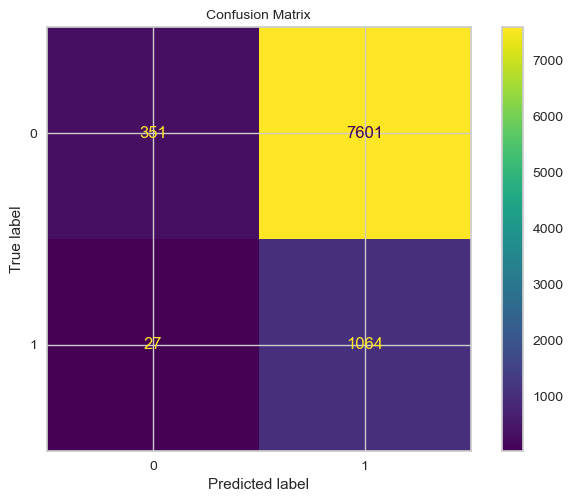

In [182]:
# Confusion matrix
cm = confusion_matrix(y_val, val_pred, labels=xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xg.classes_)
disp.plot()
plt.title('Confusion Matrix', fontsize=10)
plt.show()

`Keterangan`: Pada kasus ini, akan dicari nilai Recall (TP/(TP+FN) tertinggi yang menandakan bahwa nilai TP adalah tinggi (diprediksi berlangganan dan kenyataannya akan berlangganan) dan nilai FN adalah rendah (diprediksi tidak berlangganan dan kenyataannya ingin berlangganan). Dari beberapa model di atas, model yang memiliki nilai Recall tertinggi dan tidak overfit adalah XGBClassifier.

## Testing

In [210]:
bank_test = pd.read_csv('test.csv', sep=';')
bank_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [211]:
# Take possible features based on data understanding
list_num = ['age','balance','duration','campaign']
list_cat = ['job','marital','education','housing','loan','contact','y']
bank_prep2 = bank_test.copy()
bank_prep2 = bank_test[list_num + list_cat]
print(bank_prep2.shape)

(4521, 11)


In [212]:
# Encode categorical data
bank_prep2['marital'] = bank_prep2['marital'].replace({'married':2,'single':1,'divorced':0})
bank_prep2['education'] = bank_prep2['education'].replace({'tertiary':3,'secondary':2,'primary':1,'unknown':2})
bank_prep2['housing'] = bank_prep2['housing'].replace({'yes':1,'no':0})
bank_prep2['loan'] = bank_prep2['loan'].replace({'yes':1,'no':0})
bank_prep2['contact'] = bank_prep2['contact'].replace({'cellular':2,'telephone':1,'unknown':2})
bank_prep2['y'] = bank_prep2['y'].replace({'yes':1,'no':0})
bank_encoded2 = pd.get_dummies(bank_prep2, columns=['job'])
bank_encoded2.head()

,age,balance,duration,campaign,marital,education,housing,loan,contact,y,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,30,1787,79,1,2,1,0,0,2,0,...,0,0,0,0,0,0,0,0,1,0
1,33,4789,220,1,2,2,1,1,2,0,...,0,0,0,0,0,1,0,0,0,0
2,35,1350,185,1,1,3,1,0,2,0,...,0,0,1,0,0,0,0,0,0,0
3,30,1476,199,4,2,3,1,1,2,0,...,0,0,1,0,0,0,0,0,0,0
4,59,0,226,1,2,2,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
X = bank_encoded2.drop('y',axis=1)
Y = bank_encoded2['y']

In [214]:
X_scaled = scaler.transform(X)

In [215]:
xg.fit(X_scaled, Y)
val_pred2 = xg.predict(X_scaled)

In [216]:
print('Precision (test)\t:', precision_score(Y, val_pred2))
print('Recall (test)\t\t:', recall_score(Y, val_pred2))
print('F1-score (test)\t\t:', f1_score(Y, val_pred2))
print('ROC-AUC (test)\t\t:', roc_auc_score(Y, val_pred2))

Precision (test)	: 0.8982758620689655
Recall (test)		: 1.0
F1-score (test)		: 0.9464123524069028
ROC-AUC (test)		: 0.992625


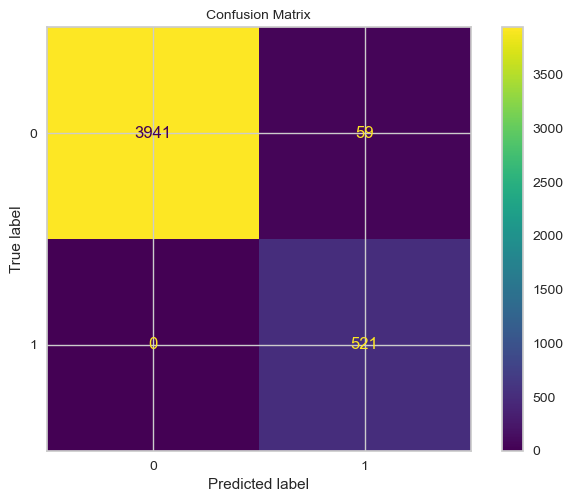

In [217]:
# Confusion matrix
cm = confusion_matrix(Y, val_pred2, labels=xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xg.classes_)
disp.plot()
plt.title('Confusion Matrix', fontsize=10)
plt.show()

## Conclusion

Berdasarkan hasil prediksi pada data test, dapat dilihat bahwa Recall bernilai 1 yang menandakan bahwa 521 orang berpotensi untuk berlangganan deposito berjangka. <br>
`Note`: Percobaan kecil ini masih dapat dilakukan penelitian lebih lanjut mulai dari tahap EDA, processing, hingga modelling, mengingat dataset ini pun memiliki target yang unbalanced.